# How-to for the Sliding Window Algorithm

This notebook shows how to load a pre-trained model and run the sliding window algorithm to run object detection on a complex scene containing several objects. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import cv2
import glob, os
import json

import data.data_helpers as data_helpers
import models.model_helpers as model_helpers
import models.tuning_helpers as tuning_helpers

print(tf.__version__)

2.3.0


## Get the model

Define where the model is saved and get all parameters.s

In [2]:
from tensorflow.keras.models import Sequential, save_model, load_model

# define model path
model_path = 'logs/experiments/inception_v3_semiart_2020_09_17-12:14'

# load model parameters
with open(os.path.join(model_path, 'results_classifier.json')) as fp:
    results_classifier = json.load(fp)
    
classes = results_classifier['classes']
ind2class = results_classifier['ind2class']
ind2class = {int(k):v for (k,v) in ind2class.items()}

# load model
loaded_model = load_model(
    model_path,
    custom_objects=None,
    compile=True
)

## Get the data

 - First, we load the base dataframe which points to all images in the __validation set__. We have to use the validation set here, to get an unbiased overall score of end-to-end object recognition pipeline.
 
  - For validation, we use a two-fold approach: 
     - Validation on an artifically generated dataset with randomized objects from the validation set.
     - Validation on completely unseend images, realistic fridge scenes which were manually selected before. 
 
 
 - We could theoretically, use base dataframe, to generate a new artificial dataset with randomize object positions (this is shown in the commented block). Alternatively, artifical datasets can be created with the script *data/generate_artifical_validation_set.py*
 
 - Instead of generating a new artificial dataset here, we just load one which is already contained in the folder *data/validation_artificial*.
 


In [3]:
# get validation set with "real" fridge scenes
val_real_data = data_helpers.get_validation_dict('data/validation_real/', classes, verbose=0)

# get validation set with "artificial" fridge scenes
val_artificial_data = data_helpers.get_validation_dict('data/validation_artificial/', classes, verbose=0)

# get test set
test_data = data_helpers.get_validation_dict('data/test_set/', classes, verbose=0)

In [4]:
### GENERATE NEW ARTIFICIAL VALIDATION SET

#N_samples = 10
#N_min = 5
#N_max = 10
#spacing = 150
#size_jitter=(0.9,1.5)
#seed = 11
#bg_path = 'data/artificial_background'

#val_artificial_data = data_helpers.generate_artifical_validation_dataset(data_df_test, bg_path, N_samples, N_min, N_max, spacing, size_jitter, seed)

Text(0.05, 0.98, 'chocolate\nlettuce\nlemon\nolive\ncarrot')

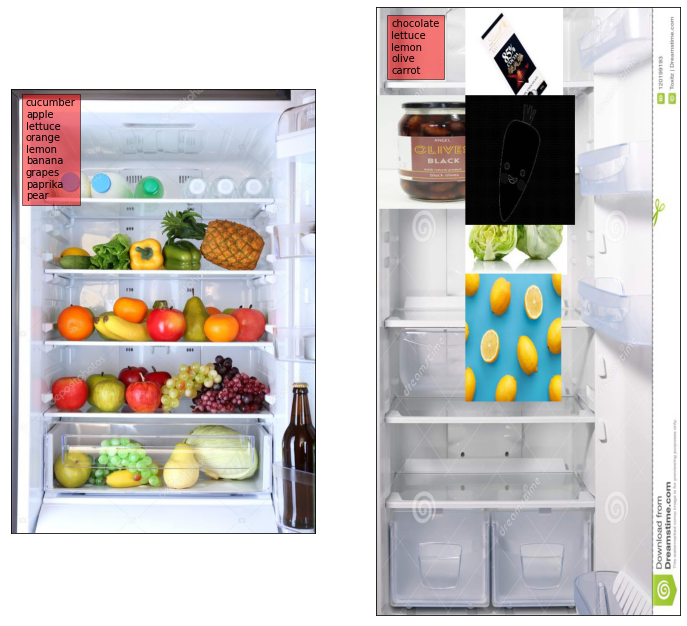

In [5]:
# show examples pictures

plt.figure(figsize=(12,12))

ax = plt.subplot(121)
plt.imshow(val_real_data[15]['image'])
plt.xticks([])
plt.yticks([])
plt.text(0.05, 0.98, '\n'.join(val_real_data[15]['labels']), 
         transform = ax.transAxes, verticalalignment='top',
         bbox=dict(facecolor='red', alpha=0.5))


ax = plt.subplot(122)
plt.imshow(val_artificial_data[15]['image'])
plt.xticks([])
plt.yticks([])
plt.text(0.05, 0.98, '\n'.join(val_artificial_data[15]['labels']), 
         transform = ax.transAxes, verticalalignment='top',
         bbox=dict(facecolor='red', alpha=0.5))

## Detect objects using "image pyramid"

    - First, generate an "image pyramid", i.e. scale the given image by different factors to enable object detection of 
    differently sized objects. 
    
    - Here, for simplicity, we only use one scaling factor. (So this is not really an image pyramid)
    
    - Run non-maximum suppression on predicted boxes.
    
For more info on the "image pyramid" see, e.g.:
https://www.pyimagesearch.com/2018/05/14/a-gentle-guide-to-deep-learning-object-detection/

In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet_v2
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3

# define correct pre-processing function for the network
preprocess_func = preprocess_inception_v3

# define correct input size for the network (the one it was trained on)
kernel_size = 224

# define selection threshold / do not take prediction with a lesser confidence level
thr = 0.87

# define non-max suppression threshold
overlap_thr = 0.2

# define image pyramid (object sizes / larger factors correspond to smaller objects)
scaling_factors = [1.5]
sliding_strides = [64]

# select image to perform predictions on
#input_sample = val_artificial_data[15]
#input_sample = val_real_data[16]
input_sample = test_data[35]
img = input_sample['image']

# perform object detection with final model
pred_labels, probabilities, x0, y0, windowsize = \
        model_helpers.object_detection_sliding_window(model=loaded_model, 
                                                      input_img=img, 
                                                      preprocess_function=preprocess_func, 
                                                      kernel_size=kernel_size, 
                                                      ind2class=ind2class, 
                                                      scaling_factors=scaling_factors, 
                                                      sliding_strides=sliding_strides, 
                                                      thr=thr, 
                                                      overlap_thr=overlap_thr)


## Evaluate and visualize results

Correctly identified: apple, scallion, corn, lemon, banana, carrot, paprika, plum, celery
Missed items: 
Wrong items: chocolate

Precision: 90.00 %
Recall: 100.00 %


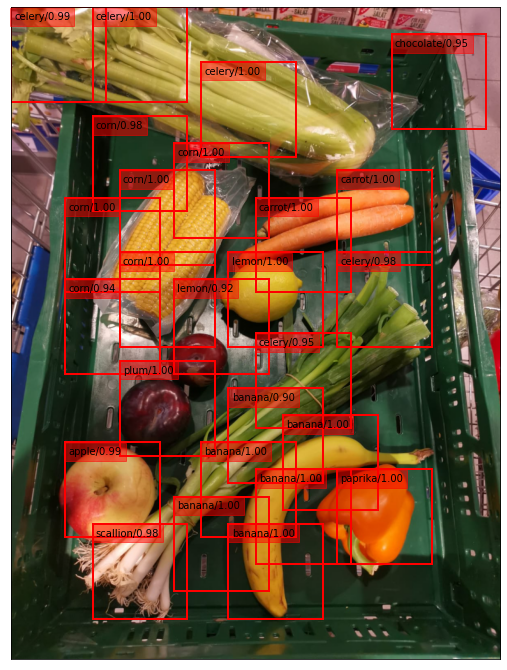

In [7]:
actual_labels = input_sample['labels']

# true positives are intersection between predicted and actual labels
TP = set(actual_labels).intersection(set(pred_labels))

# false positives are difference between predicted and actual labels
FP = set(pred_labels) - set(actual_labels)

# false negatives are difference between actual and predicted labels
FN = set(actual_labels) - set(pred_labels)

# true negatives are intersection between the differences between all classes 
# and the actual and predicted classes respectively
# (usually not so important for object detection)
TN = (set(classes) - set(actual_labels)).intersection((set(classes) - set(pred_labels)))

precision = len(TP) / (len(TP)+len(FP))
recall  = len(TP) / (len(TP)+len(FN))

print(f'Correctly identified: ' + ', '.join(TP))
print(f'Missed items: ' + ', '.join(FN))
print(f'Wrong items: ' + ', '.join(FP))
print()
print(f'Precision: {100*precision:.2f} %')
print(f'Recall: {100*recall:.2f} %')

# visualize results
fig = model_helpers.visualize_predictions(img, 
                                          pred_labels, 
                                          probabilities, 
                                          x0, 
                                          y0,
                                          windowsize)


### Measure inference time

In [ ]:
import time
t1 = time.time()
pred_labels, probabilities, x0, y0, windowsize = \
        model_helpers.object_detection_sliding_window(model=loaded_model, 
                                                      input_img=img, 
                                                      preprocess_function=preprocess_func, 
                                                      kernel_size=kernel_size, 
                                                      ind2class=ind2class, 
                                                      scaling_factors=scaling_factors, 
                                                      sliding_strides=sliding_strides, 
                                                      thr=thr, 
                                                      overlap_thr=overlap_thr)
print(time.time()-t1)

### Generate model predictions on whole test set

- Iterate over whole test set and make predicitions
- Save results / visualizations
- Get performance metrics on test set

In [ ]:
results = []

for ind in test_data.keys():
    
    input_sample = test_data[ind]
    img = input_sample['image']
    
    # perform object detection with final model
    pred_labels, probabilities, x0, y0, windowsize = \
            model_helpers.object_detection_sliding_window(model=loaded_model, 
                                                          input_img=img, 
                                                          preprocess_function=preprocess_func, 
                                                          kernel_size=kernel_size, 
                                                          ind2class=ind2class, 
                                                          scaling_factors=scaling_factors, 
                                                          sliding_strides=sliding_strides, 
                                                          thr=thr, 
                                                          overlap_thr=overlap_thr)
    
    # get metrics
    actual_labels = input_sample['labels']
    accuracy, precision, recall, TP, FP, TN, FN = tuning_helpers.get_evaluation_metrics(actual_labels, pred_labels, classes)
    
    # visualize results
    fig = model_helpers.visualize_predictions(img, 
                                              pred_labels, 
                                              probabilities, 
                                              x0, 
                                              y0,
                                              windowsize)
    
#    # save visualization
#    savepath = os.path.join(model_path, 'figures', 'results', 'test')
#    if not os.path.isdir(savepath):
#        os.makedirs(savepath)
#    fig.savefig(os.path.join(savepath, f'img_{ind}.png'), bbox_inches='tight', dpi=300)
    
    # log metrics
    log = {'i_img': ind,
           'accuracy': accuracy,
           'precision': precision,
           'recall': recall}
            
    results.append(log)
    

#with open(os.path.join(savepath, 'test_resuts.json'), 'w+') as fp:
#    json.dump(results, fp)
    
results_df = pd.DataFrame(results)

In [ ]:
results_df['f1'] = 2*results_df['precision']*results_df['recall'] / (results_df['precision']+results_df['recall'])
results_df.mean(0)